In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
from huggingface_hub import hf_hub_download
import pandas as pd

path = hf_hub_download(
    repo_id="MoSBAIHI/weld-quality-dataset",
    filename="data/train-00000-of-00001.parquet",
    repo_type="dataset"
)

df = pd.read_parquet(path)

In [35]:
TARGET_COLS = [
    "yield_strength_MPa",  # Stress at which plastic deformation begins; measures material strength.
    "uts_MPa",             # Ultimate tensile strength; maximum stress material can withstand before fracture.
    "elongation_pct",      # Percent elongation; measure of ductility (total strain before fracture).
    "reduction_area_pct",  # Percent reduction in cross-sectional area after fracture; another ductility measure.
    "charpy_temp_C",       # Test temperature for Charpy impact test; defines testing condition.
    "charpy_toughness_J", ] # Charpy impact energy absorbed; indicates toughness and resistance to brittle fracture.

X = df.drop(columns=TARGET_COLS)
y = df[TARGET_COLS]

Missing Values Analysis:
Number of columns with >80% missing values: 11
Number of columns with 30-80% missing values: 8
Number of columns with 0-30% missing values: 9
Number of columns with no missing values: 20


,column,missing_count,missing_percentage,data_type,action
tungsten_wt_pct,tungsten_wt_pct,1589,0.961864,float64,drop
boron_ppm,boron_ppm,1567,0.948547,float64,drop
ferrite_carbide_pct,ferrite_carbide_pct,1563,0.946126,float64,drop
martensite_pct,martensite_pct,1563,0.946126,float64,drop
acicular_ferrite_pct,acicular_ferrite_pct,1562,0.945521,float64,drop
ferrite_second_phase_pct,ferrite_second_phase_pct,1562,0.945521,float64,drop
primary_ferrite_pct,primary_ferrite_pct,1556,0.941889,float64,drop
cobalt_wt_pct,cobalt_wt_pct,1544,0.934625,float64,drop
arsenic_ppm,arsenic_ppm,1426,0.863196,float64,drop
antimony_ppm,antimony_ppm,1398,0.846247,float64,drop


Dropping columns with >80.0% missing values: ['cobalt_wt_pct', 'tungsten_wt_pct', 'boron_ppm', 'tin_ppm', 'arsenic_ppm', 'antimony_ppm', 'primary_ferrite_pct', 'ferrite_second_phase_pct', 'acicular_ferrite_pct', 'martensite_pct', 'ferrite_carbide_pct']
sulfur_wt_pct: 0.67% missing -> median
phosphorus_wt_pct: 0.61% missing -> median
nickel_wt_pct: 57.81% missing -> drop_or_domain_specific
chromium_wt_pct: 52.54% missing -> drop_or_domain_specific
molybdenum_wt_pct: 52.12% missing -> drop_or_domain_specific
vanadium_wt_pct: 62.47% missing -> drop_or_domain_specific
copper_wt_pct: 65.86% missing -> drop_or_domain_specific
oxygen_ppm: 23.97% missing -> iterative
titanium_ppm: 47.64% missing -> drop_or_domain_specific
nitrogen_ppm: 28.39% missing -> iterative
aluminium_ppm: 69.61% missing -> drop_or_domain_specific
niobium_ppm: 72.58% missing -> drop_or_domain_specific
current_A: 15.01% missing -> iterative
voltage_V: 15.01% missing -> iterative
interpass_temp_C: 2.30% missing -> mean
pwht

/Users/mohammedsbaihi/Code/weld-quality/weld-pred/lib/python3.13/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(



Validating imputation quality...


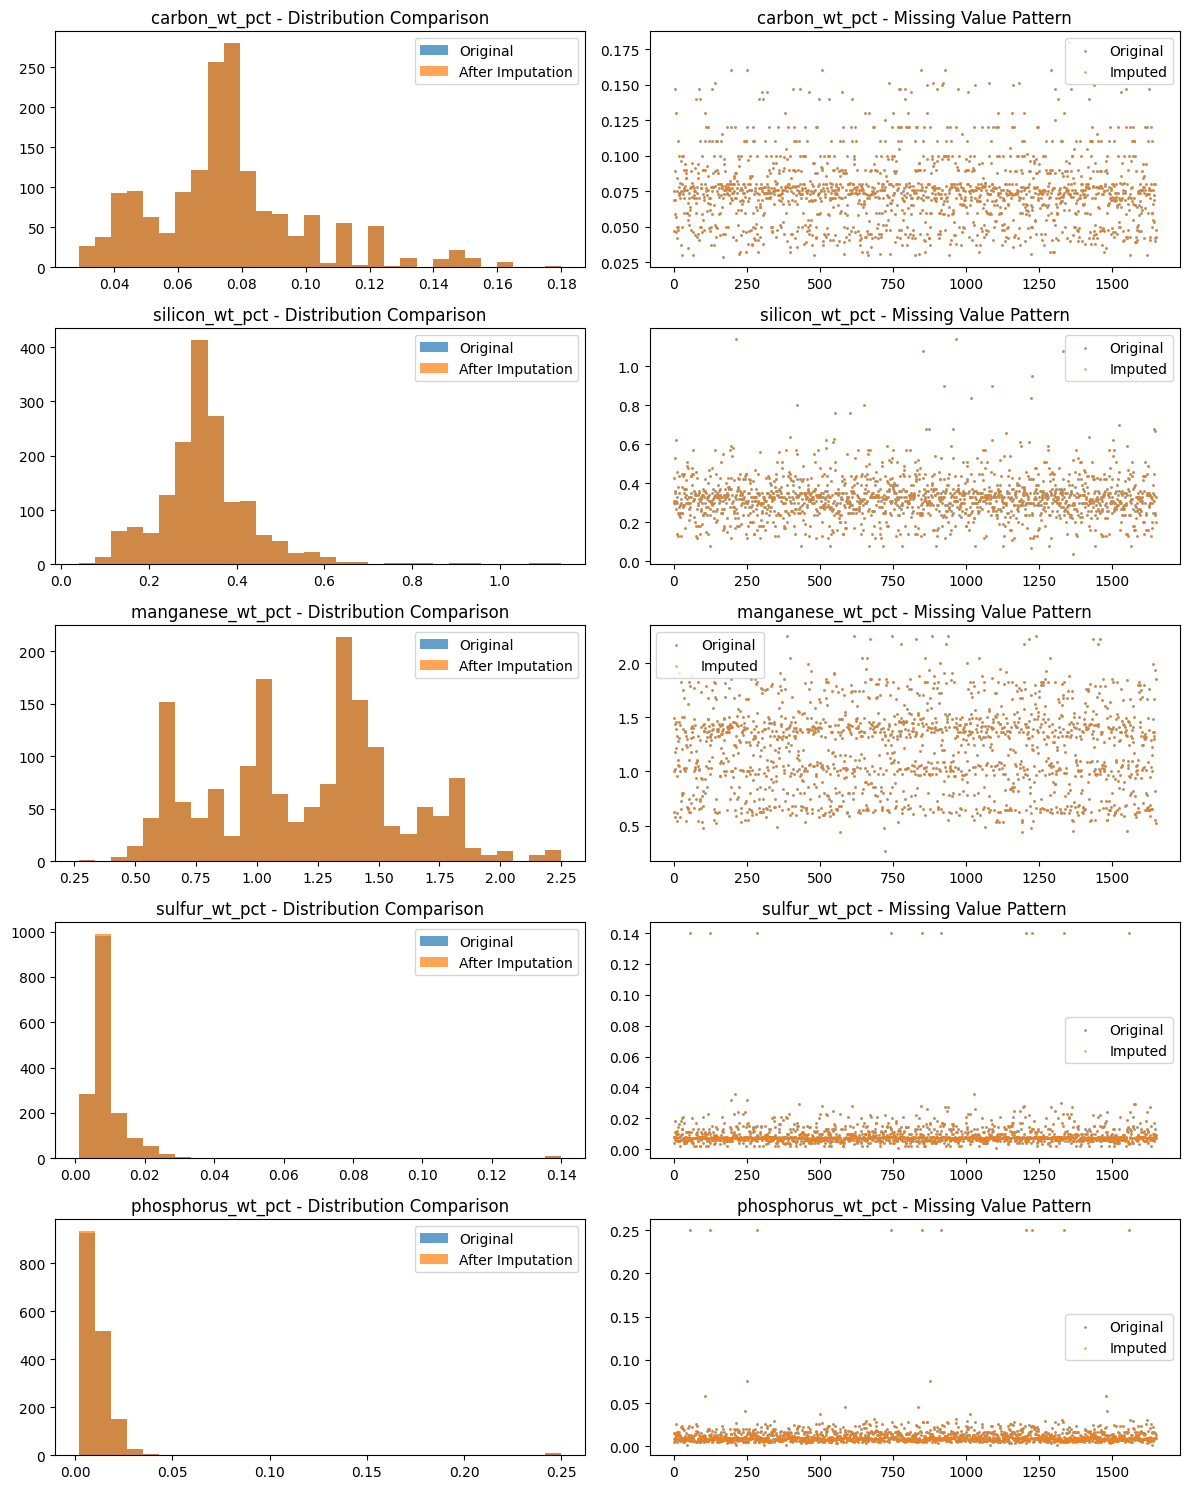


Original shape: (1652, 48)
After removing high-missing columns: (1652, 37)
Missing values after imputation: 0


In [36]:
from analytics_utils import (
    analyze_missing_values,
    remove_high_missing_columns,
    choose_imputation_strategy,
    apply_imputation,
    validate_imputation
)
missing_analysis = analyze_missing_values(X, threshold=0.8)
print("Missing Values Analysis:")
print("Number of columns with >80% missing values:", (missing_analysis['action'] == 'drop').sum())
print("Number of columns with 30-80% missing values:", (missing_analysis['action'] == 'impute_carefully').sum())
print("Number of columns with 0-30% missing values:", (missing_analysis['action'] == 'impute_standard').sum())
print("Number of columns with no missing values:", (missing_analysis['action'] == 'keep').sum())
display(missing_analysis.head(10))
X_cleaned, dropped_cols = remove_high_missing_columns(X, threshold=0.8)
imputation_strategies = {}
for column in X_cleaned.columns:
    missing_pct = X_cleaned[column].isnull().sum() / len(X_cleaned)
    if missing_pct > 0:
        strategy = choose_imputation_strategy(X_cleaned, column, missing_pct)
        imputation_strategies[column] = strategy
        print(f"{column}: {missing_pct:.2%} missing -> {strategy}")
X_imputed = apply_imputation(X_cleaned, imputation_strategies)
# Validate the imputation
print("\nValidating imputation quality...")
validate_imputation(X_cleaned, X_imputed)

# # Final check
print(f"\nOriginal shape: {X.shape}")
print(f"After removing high-missing columns: {X_cleaned.shape}")
print(f"Missing values after imputation: {X_imputed.isnull().sum().sum()}")



Explained variance by component:
PC1: 15.09%
PC2: 12.43%


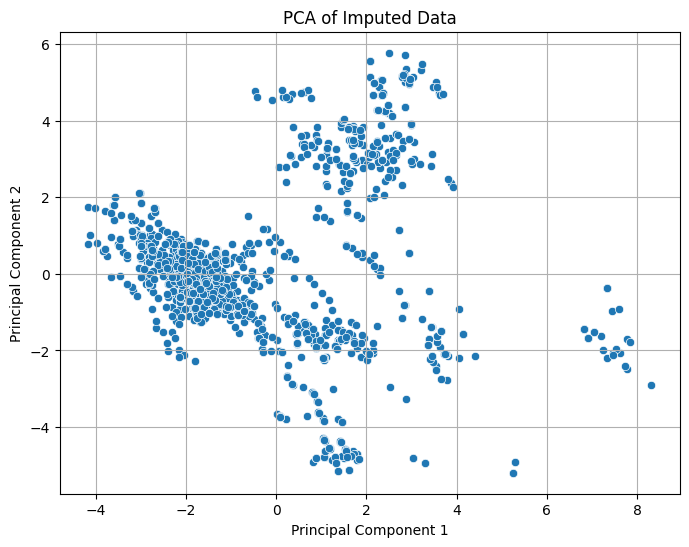

In [42]:
# let's apply PCA on x_imputed for 2D visualization using seaborn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# explain variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by component:\nPC1: {explained_variance[0]:.2%}\nPC2: {explained_variance[1]:.2%}")

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1])
plt.title("PCA of Imputed Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

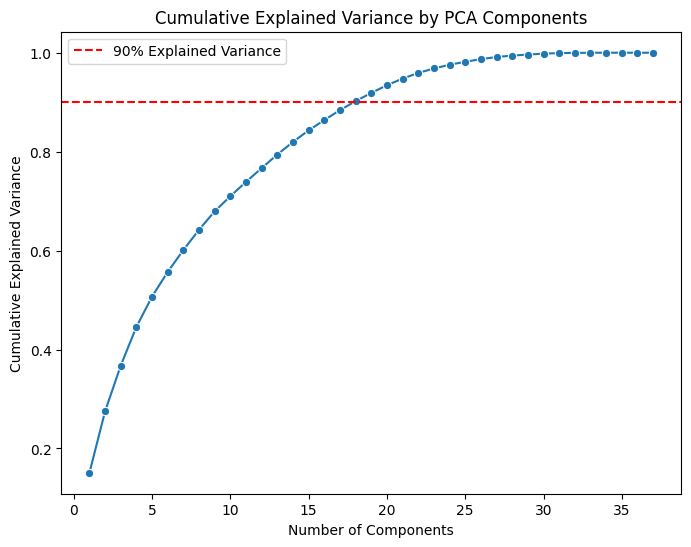

In [41]:
# cumulative explained variance plot using seaborn
import numpy as np
pca_full = PCA().fit(X_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1, len(cumulative_variance) + 1), y=cumulative_variance, marker='o')
plt.title("Cumulative Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
plt.legend()

Explained variance ratio: [0.10711262 0.08932457]


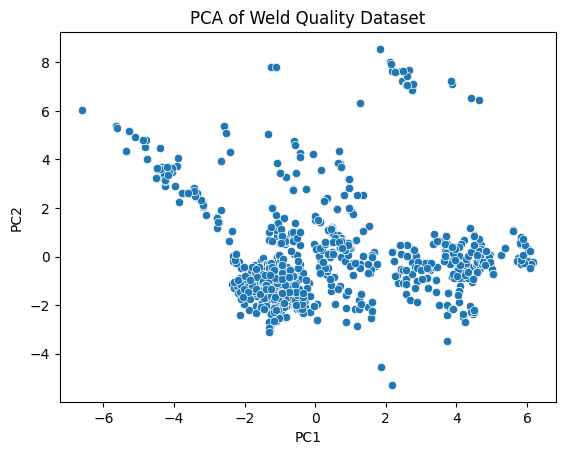

In [7]:
# before PCA, let's impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# PCA Implementation
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Visualizing PCA results using seaborn
import seaborn as sns
import matplotlib.pyplot as plt
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
sns.scatterplot(data=pca_df, x='PC1', y='PC2')
plt.title('PCA of Weld Quality Dataset')
plt.show()